### looking at 600 epochs of data augmented cnn run
model is [v2.py](v2.py)

The purpose is to check if using multiple models to predict the digit is better or not.
Spoiler!!!: => I get about 99.79% accuracy on the 10,000 test data.

Let's read the saved validation accuracy to check what was the median value

In [18]:
import numpy as np
import glob



### read saved history data
The graph shows that during data augmented training, the training nor validation loss/accuracy really improves.

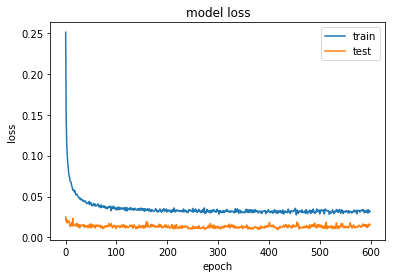

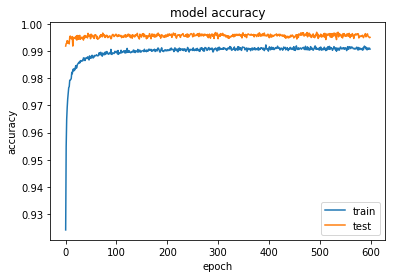

In [27]:
loss = np.load('loss.npy')
val_loss = np.load('val_loss.npy')
acc = np.load('acc.npy')
val_acc=np.load('val_acc.npy')

from matplotlib import pyplot as plt
%matplotlib inline

# show procession of training...
plt.plot(loss)
plt.plot(val_loss)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.close()

plt.plot(acc)
plt.plot(val_acc)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
plt.close()

### histogram of the val_acc
Using the histogram shows what the "average" prediction rate was during data augmented training.

Some dashboard claim very selective error rate vs citing what the highest frequency rate is.

If someone is saving the "random seed" for his model, that you must suspect the modeller is seeking for that very special situation where the error rate was the lowest.

During 600 epoch run, I only reach upto 0.9970 validation accuracy rate.

median: 0.9958


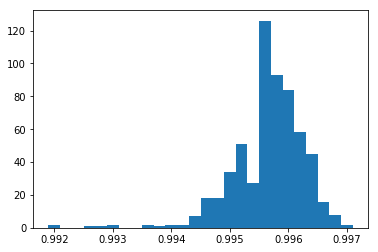

In [20]:
print('median:',  np.median(val_acc))
binwidth=0.0002
plt.hist(val_acc, bins=np.arange(min(val_acc), max(val_acc) + binwidth, binwidth))
plt.show()
plt.close()

### let's read 3 good models
The purpose is to use consensus model:
you have two experts (or slaves as used in this notebook) on digit prediction. 
If they agree on the guess, then the agreed number is the prediction value

If they disagree, then the "master" picks his number as the correct prediction


In [21]:
saved_dir='saved_models'

model_names = glob.glob(saved_dir + "/*.hdf5")
sorted_names = sorted(model_names , reverse=True)
print(sorted_names)



['saved_models\\va0.9970-e0537-a0.99117-l0.03059-vl0.01109.hdf5', 'saved_models\\va0.9970-e0495-a0.99070-l0.03479-vl0.01153.hdf5', 'saved_models\\va0.9969-e0296-a0.99118-l0.03117-vl0.01124.hdf5']


In [22]:
from tensorflow import keras

# get mnist data
mnist = keras.datasets.mnist

print('loading MNIST data...')
# using path saves to the ~/.keras/data/path location so it's not downloaded next time
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# shape data for CNN

# convert the shape of data depending on the image data format
is_channels_first = (keras.backend.image_data_format() == 'channels_first')

if is_channels_first :
    x_train2 = x_train.reshape(x_train.shape[0], 1, 28, 28)
    x_test2 = x_test.reshape(x_test.shape[0], 1, 28, 28)
else:
    x_train2 = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test2 = x_test.reshape(x_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# get hot label output

y_train2 = keras.utils.to_categorical(y_train, num_classes=10)
y_test2 = keras.utils.to_categorical(y_test, num_classes=10)

# normalize the data
x_train2 = x_train2.astype('float32')
x_test2 = x_test2.astype('float32')

# convert the data from 0 to 1.0
x_train2, x_test2 = x_train2 / 255, x_test2 / 255

print('x train shape:',x_train2.shape)
print('y train shape:',y_train2.shape)
print('x test shape:',x_test2.shape)
print('y test shape:',y_test2.shape)



loading MNIST data...
x train shape: (60000, 28, 28, 1)
y train shape: (60000, 10)
x test shape: (10000, 28, 28, 1)
y test shape: (10000, 10)


### read and show confusion matrix
The model at 0 and 1 have 99.70% val_acc rate and both were achieved not far from epochs while the model2 was picked from around 250 ish epoch and has 99.68%

In [23]:

model = keras.models.load_model(sorted_names[2])
slave1 = keras.models.load_model(sorted_names[0])
slave2 = keras.models.load_model(sorted_names[1])

In [24]:
# process data through 3 models and predict using the above 3 model protocol:
# if two slaves agree then that is the prediction, else, the master picks

predictions = model.predict(x_test2)
slave1_pred = slave1.predict(x_test2)
slave2_pred = slave2.predict(x_test2)

my_matrix = np.zeros( (10,10), dtype='int')

# count of good guesses
count_matrix = np.zeros( (10,), dtype='int')
good_matrix = np.zeros( (10,), dtype='int')
miss_count = 0;

# iterate through 10,000 test data
for i in range(10000):
    count_matrix[y_test[i]] +=1
    guess = np.argmax(predictions[i])
    s1_guess = np.argmax(slave1_pred[i])
    s2_guess = np.argmax(slave2_pred[i])
    
    if s1_guess == s2_guess:
        guess = s1_guess
    
    if guess == y_test[i]:
        good_matrix[guess] +=1
    else:
        # increment [expected][guess] matrix
        my_matrix[y_test[i]][guess] += 1
        miss_count +=1

# show good matrix
print('missed count:', miss_count , 'ouf of 10,000')
print('Good guesses:')
for i in range(10):
    percent = "( {:.2f}".format((good_matrix[i] * 100.0) / count_matrix[i]) + " %)"
    print('match count for:',i,'=', good_matrix[i] , '/',count_matrix[i] , percent, 'missed:', count_matrix[i] - good_matrix[i])


missed count: 21 ouf of 10,000
Good guesses:
match count for: 0 = 980 / 980 ( 100.00 %) missed: 0
match count for: 1 = 1134 / 1135 ( 99.91 %) missed: 1
match count for: 2 = 1030 / 1032 ( 99.81 %) missed: 2
match count for: 3 = 1010 / 1010 ( 100.00 %) missed: 0
match count for: 4 = 980 / 982 ( 99.80 %) missed: 2
match count for: 5 = 889 / 892 ( 99.66 %) missed: 3
match count for: 6 = 956 / 958 ( 99.79 %) missed: 2
match count for: 7 = 1026 / 1028 ( 99.81 %) missed: 2
match count for: 8 = 970 / 974 ( 99.59 %) missed: 4
match count for: 9 = 1004 / 1009 ( 99.50 %) missed: 5



Confusion Matrix


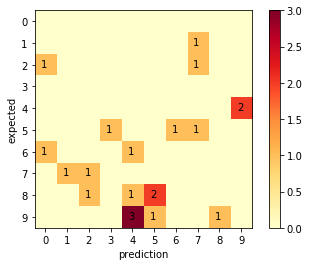

In [25]:
print('\nConfusion Matrix')

fig = plt.figure()
plt.xticks( range(10))
plt.yticks( range(10))

for y in range(10):
    for x in range(10):
        if my_matrix[y][x] != 0:
            # put text
            plt.text( x-len(str(x)) * 0.2, y+0.1, str(my_matrix[y][x]))
plt.xlabel('prediction')
plt.ylabel('expected')
plt.imshow(my_matrix, cmap='YlOrRd')
plt.colorbar()
plt.show()
plt.close()

Expected: 9 , predicted: 4


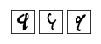

In [26]:
expected_number = 9
guessed_number = 4

print('Expected:', expected_number, ', predicted:', guessed_number)
non_match_list = []
for i in range(10000):
    if y_test[i] == expected_number:
        guess = np.argmax(predictions[i])
            
        s1_guess = np.argmax(slave1_pred[i])
        s2_guess = np.argmax(slave2_pred[i])

        if s1_guess == s2_guess:
            guess = s1_guess
            
        if guess == guessed_number:
            non_match_list.append(i)

fig = plt.figure( figsize = (10,2))

for i in range(len(non_match_list)):
    plt.subplot(1,20,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = non_match_list[i]
    plt.imshow(x_test[index], cmap='gray_r')
plt.show()
plt.close()